# Quantum Algorithms/ Quanutm Computing week 6 exercise

1. Show that the 4x4 matrix made up of the 2x2 identity $I$ and a 2x2 unitary operator $U$ is a *controlled-$U$* gate if it is written

$$
\left(\begin{array}{cc} I & \\ & U \end{array}\right)
$$
where zeros are filled in where the array is blank.

2. From the result in 1., write out the matrix form for a controlled-$R_n$ gate

3. implement the $n=4$ QFT circuit in PennyLane and show that it gives the right output for some know result (e.g. the sawtooth wave from last week)



In [2]:
#Show the 4x4 matrix first

import numpy as np
import sympy as sp

# Define symbolic variables
U11, U12, U21, U22 = sp.symbols('U11 U12 U21 U22')

# Create the matrix
fourbyfour = sp.Matrix([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, U11, U12],
    [0, 0, U21, U22]
])

# Pretty print
sp.pprint(fourbyfour)



⎡1  0   0    0 ⎤
⎢              ⎥
⎢0  1   0    0 ⎥
⎢              ⎥
⎢0  0  U₁₁  U₁₂⎥
⎢              ⎥
⎣0  0  U₂₁  U₂₂⎦


In [3]:
#Define the matrix within Pennylane

import pennylane as qml

# Define the device
dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev)
def circuit():
    # Define the unitary matrix U
    U_matrix = np.array([
        [qml.numpy.tensor(1), qml.numpy.tensor(0)],
        [qml.numpy.tensor(0), qml.numpy.tensor(1)]
    ], dtype=np.complex128)

    # Apply controlled unitary
    qml.ctrl(qml.QubitUnitary, control=0)(U_matrix, wires=[1])

    return qml.state()

qml.matrix(circuit)()

#This shows that whatever we define U as will invoke this matrix after we apply qml.ctrl

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

In [4]:
# The controlled R_r gate is given by the below photo, we shall now create the array similarly:

dev = qml.device("default.qubit", wires=2)

def Rr_gate(r, control, target):
    """Applies the custom Rr gate."""
    theta = 2 * np.pi / (2 ** r)
    
    # Define the 2×2 matrix
    Rr_matrix = np.array([
        [1, 0],
        [0, np.exp(1j * theta)]
    ], dtype=np.complex128)  # Ensure it's a complex matrix
    
    # Apply the matrix as a unitary operation on one qubit
    qml.ctrl(qml.QubitUnitary, control=control)(Rr_matrix, wires=[target])

# Define a PennyLane device
dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev)
def circuit(r):
    Rr_gate(r,0,1)  
    return qml.state()

qml.matrix(circuit)(2)


array([[1.000000e+00+0.j, 0.000000e+00+0.j, 0.000000e+00+0.j,
        0.000000e+00+0.j],
       [0.000000e+00+0.j, 1.000000e+00+0.j, 0.000000e+00+0.j,
        0.000000e+00+0.j],
       [0.000000e+00+0.j, 0.000000e+00+0.j, 1.000000e+00+0.j,
        0.000000e+00+0.j],
       [0.000000e+00+0.j, 0.000000e+00+0.j, 0.000000e+00+0.j,
        6.123234e-17+1.j]])

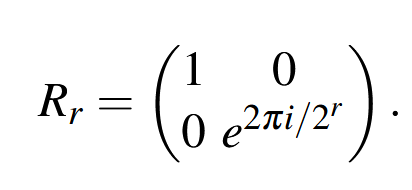

In [5]:
#doing the whole thing together applying the QFT to the all zero state
import pennylane as qml
import numpy as np

# Define a PennyLane device
num_qubits = 4  # Set number of qubits for QFT
dev = qml.device("default.qubit", wires=num_qubits, shots=1000)

def Rr_gate(r, control, target):
    """Applies the custom Rr gate."""
    theta = 2 * np.pi / (2 ** r)
    
    # Define the 2×2 matrix
    Rr_matrix = np.array([
        [1, 0],
        [0, np.exp(1j * theta)]
    ], dtype=np.complex128)  # Ensure it's a complex matrix
    
    # Apply the matrix as a controlled unitary operation
    qml.ctrl(qml.QubitUnitary, control=control)(Rr_matrix, wires=[target])

def qft(n):
    """Quantum Fourier Transform using Rr controlled phase gates."""
    
    for i in range(n):
        qml.Hadamard(wires=i)  # Apply Hadamard to start superposition
        for j in range(i+1, n):
            Rr_gate(r=j-i+1, control=j, target=i)  # Apply controlled Rr gate

    # Swap qubits to match conventional QFT output
    for i in range(n // 2):
        qml.SWAP(wires=[i, n - i - 1])

@qml.qnode(dev)
def qft_circuit():
    """Quantum circuit that applies the QFT on |00⟩ state."""
    
    # Apply the QFT
    qft(num_qubits)
    
    # Return the quantum probabilities for each state
    return qml.probs()

# Execute the QFT circuit
output_state = qft_circuit()

# Print the resulting quantum state
print("Output quantum state:", output_state)


Output quantum state: [0.056 0.073 0.059 0.069 0.057 0.067 0.062 0.063 0.057 0.045 0.066 0.073
 0.067 0.059 0.063 0.064]


Now we just slightly alter the code to encode the sawtooth wave function f(x) = x - pi

In [6]:
import pennylane as qml
from pennylane import numpy as np

# Define number of qubits
n_wires = 4

# Generate sawtooth function values
num_basis_states = 2**n_wires
x_vals = np.linspace(0, 2 * np.pi, num_basis_states, endpoint=False)  # 16 points
sawtooth_vals = x_vals - np.pi  # Apply f(x) = x - π

# Normalize to get valid amplitudes
norm = np.sqrt(np.sum(sawtooth_vals ** 2))
amplitudes = sawtooth_vals / norm

print("Normalized amplitudes rounded to 3dp:", np.round(amplitudes, 3))

# Compute the squared amplitudes and make them positive
#amplitudes_squared = np.abs(amplitudes ** 2)
#print("Amplitudes squared and positive:", amplitudes_squared)


Normalized amplitudes rounded to 3dp: [-0.431 -0.377 -0.323 -0.27  -0.216 -0.162 -0.108 -0.054  0.     0.054
  0.108  0.162  0.216  0.27   0.323  0.377]


Method 1: Motten State Preparation into QML DRAW then use manual gates to create starting state

In [7]:
qml.templates.MottonenStatePreparation.compute_decomposition(amplitudes, wires=range(n_wires))

[RY(tensor(1.38365946, requires_grad=True), wires=[0]),
 RY(tensor(1.64260991, requires_grad=True), wires=[1]),
 CNOT(wires=[0, 1]),
 RY(tensor(-0.85548164, requires_grad=True), wires=[1]),
 CNOT(wires=[0, 1]),
 RY(tensor(1.65909762, requires_grad=True), wires=[2]),
 CNOT(wires=[1, 2]),
 RY(tensor(0.27480313, requires_grad=True), wires=[2]),
 CNOT(wires=[0, 2]),
 RY(tensor(-0.06168328, requires_grad=True), wires=[2]),
 CNOT(wires=[1, 2]),
 RY(tensor(-0.6049091, requires_grad=True), wires=[2]),
 CNOT(wires=[0, 2]),
 RY(tensor(1.70813312, requires_grad=True), wires=[3]),
 CNOT(wires=[2, 3]),
 RY(tensor(0.20645829, requires_grad=True), wires=[3]),
 CNOT(wires=[1, 3]),
 RY(tensor(0.09958887, requires_grad=True), wires=[3]),
 CNOT(wires=[2, 3]),
 RY(tensor(0.27544604, requires_grad=True), wires=[3]),
 CNOT(wires=[0, 3]),
 RY(tensor(-0.12223626, requires_grad=True), wires=[3]),
 CNOT(wires=[2, 3]),
 RY(tensor(-0.17746976, requires_grad=True), wires=[3]),
 CNOT(wires=[1, 3]),
 RY(tensor(-0.10

(<Figure size 5500x500 with 1 Axes>, <Axes: >)


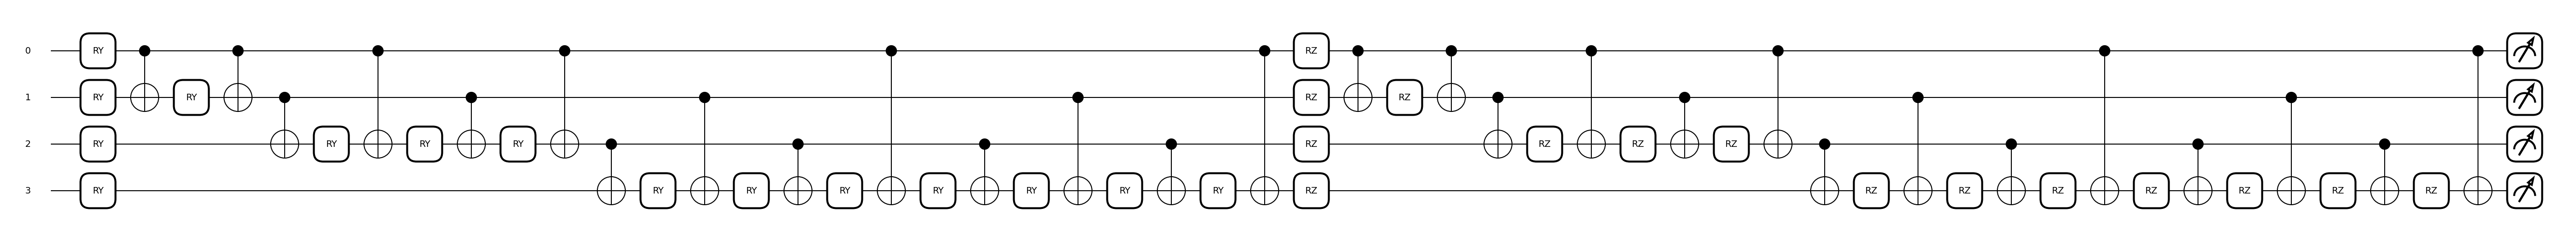

In [8]:
# Create a 16x16 diagonal matrix with amplitudes on the diagonal
amplitudes_matrix = np.diag(amplitudes)
#print(amplitudes_matrix)
qml.pauli_decompose(amplitudes_matrix)


@qml.qnode(dev)
def circuit():
    # Apply Mottonen state preparation
    qml.templates.MottonenStatePreparation(amplitudes, wires=range(n_wires))

    return qml.state()


#drawer_simple = qml.draw(circuit, level=3,decimals = 4, show_matrices=True)
drawer_nice = qml.draw_mpl(circuit, level=3, show_matrices=True)
#print(drawer_simple())
print(drawer_nice())


def decomposed_circuit():
    """Quantum circuit that applies CNOT, RY and RZ gates on |0000⟩ state to encode the Sawtooth Wavefunction."""
    # Apply all the gates
    qml.RY(1.3837, wires=0)
    qml.RY(1.6426, wires=1)
    qml.RY(1.6591, wires=2)
    qml.RY(1.7081, wires=3)
    qml.CNOT(wires=[0, 1])
    qml.RY(-0.8555, wires=1)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.RY(0.2756, wires=2)
    qml.CNOT(wires=[0, 2])
    qml.RY(-0.0622, wires=2)
    qml.CNOT(wires=[1, 2])
    qml.RY(-0.6041, wires=2)
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[2, 3])
    qml.RY(0.2060, wires=3)
    qml.CNOT(wires=[1, 3])
    qml.RY(0.0992, wires=3)
    qml.CNOT(wires=[2, 3])
    qml.RY(0.2757, wires=3)
    qml.CNOT(wires=[0, 3])
    qml.RY(-0.1218, wires=3)
    qml.CNOT(wires=[2, 3])
    qml.RY(-0.1779, wires=3)
    qml.CNOT(wires=[1, 3])
    qml.RY(-0.1049, wires=3)
    qml.CNOT(wires=[2, 3])
    qml.RY(-0.4475, wires=3)
    qml.CNOT(wires=[0, 3])
    qml.RZ(-3.1416, wires=0)
    #qml.RZ(0.0000, wires=1)
    #qml.RZ(0.0000, wires=2)
    #qml.RZ(0.0000, wires=3)
    qml.CNOT(wires=[0, 1])
    #qml.RZ(0.0000, wires=1)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    #qml.RZ(0.0000, wires=2)
    qml.CNOT(wires=[0, 2])
    #qml.RZ(0.0000, wires=2)
    qml.CNOT(wires=[1, 2])
    #qml.RZ(0.0000, wires=2)
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[2, 3])
    #qml.RZ(0.0000, wires=3)
    qml.CNOT(wires=[1, 3])
    #qml.RZ(0.0000, wires=3)
    qml.CNOT(wires=[2, 3])
    #qml.RZ(0.0000, wires=3)
    qml.CNOT(wires=[0, 3])
    #qml.RZ(0.0000, wires=3)
    qml.CNOT(wires=[2, 3])
    #qml.RZ(0.0000, wires=3)
    qml.CNOT(wires=[1, 3])
    #qml.RZ(0.0000, wires=3)
    qml.CNOT(wires=[2, 3])
    #qml.RZ(0.0000, wires=3)
    qml.CNOT(wires=[0, 3])
    qml.GlobalPhase(-1.5708)
    #no return needed as this is just a component

#59 gates required, and RY can be decomposed into RZ(pi/2)RX(theta)RZ(-pi/2) so we can use 3 gates to replace 1 RY gate
# There are 16 RY gates in the decomposed_circuit() function
#Therefore 59-16 + 16*3 = 59 + 16*2 = 91 gates required in fundamental gates


We check that if we qft our decomposed circuit, do we get a similar classical yield? (ofc we do!)

Output quantum state: [0.01162191 0.30573994 0.07940342 0.03753338 0.02313748 0.01681682
 0.01366437 0.0120933  0.01160364 0.01209329 0.01366437 0.0168168
 0.02313748 0.03753327 0.07940342 0.30573712]


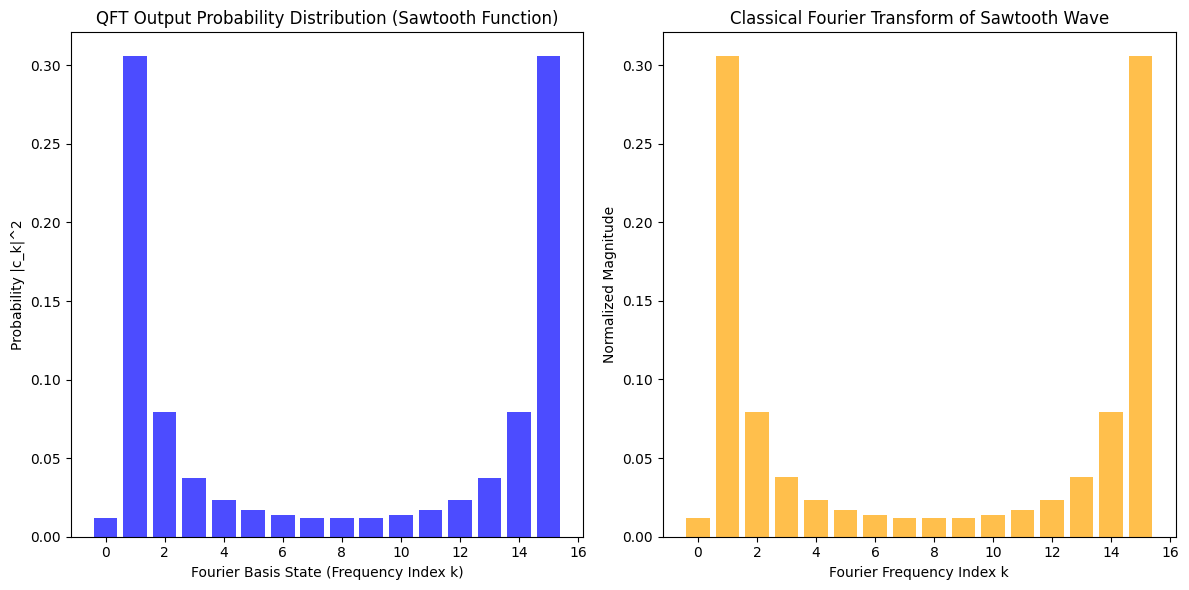

In [9]:
dev = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(dev)
def circuit():
    # Apply the decomposed circuit
    decomposed_circuit()
    qft(num_qubits)
    return qml.probs()

#--------------------------------------Plottting the results--------------------------------------------
# Execute the QFT circuit
output_state = circuit()

# Print the resulting quantum state
print("Output quantum state:", output_state)

#-----------------------------------Plotting-----------------------------------

import matplotlib.pyplot as plt

# Classical Fourier Transform of the sawtooth wave
classical_fft = np.fft.fft(sawtooth_vals)
classical_probs = np.abs(classical_fft) ** 2
classical_probs /= np.sum(classical_probs)  # Normalize probabilities

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Quantum Fourier Transform output
ax1.bar(range(len(output_state)), output_state, color='blue', alpha=0.7)
ax1.set_title("QFT Output Probability Distribution (Sawtooth Function)")
ax1.set_xlabel("Fourier Basis State (Frequency Index k)")
ax1.set_ylabel("Probability |c_k|^2")

# Classical Fourier Transform output
ax2.bar(range(len(classical_probs)), classical_probs, color='orange', alpha=0.7)
ax2.set_title("Classical Fourier Transform of Sawtooth Wave")
ax2.set_xlabel("Fourier Frequency Index k")
ax2.set_ylabel("Normalized Magnitude")

plt.tight_layout()
plt.show()

Method 2: Create a qml Qubit Unitary with U = amplitudes 16 by 16 matrix but only on the first column such that it converts the all zero state to the amplitude state 

[-0.431+0.j -0.377+0.j -0.323+0.j -0.27 +0.j -0.216+0.j -0.162+0.j
 -0.108+0.j -0.054+0.j  0.   +0.j  0.054+0.j  0.108+0.j  0.162+0.j
  0.216+0.j  0.27 +0.j  0.323+0.j  0.377+0.j]
Output quantum state: [0.01161006 0.30581625 0.07914846 0.03747247 0.02316631 0.01680197
 0.01362441 0.01207856 0.01161006 0.01207856 0.01362441 0.01680197
 0.02316631 0.03747247 0.07914846 0.30581625]


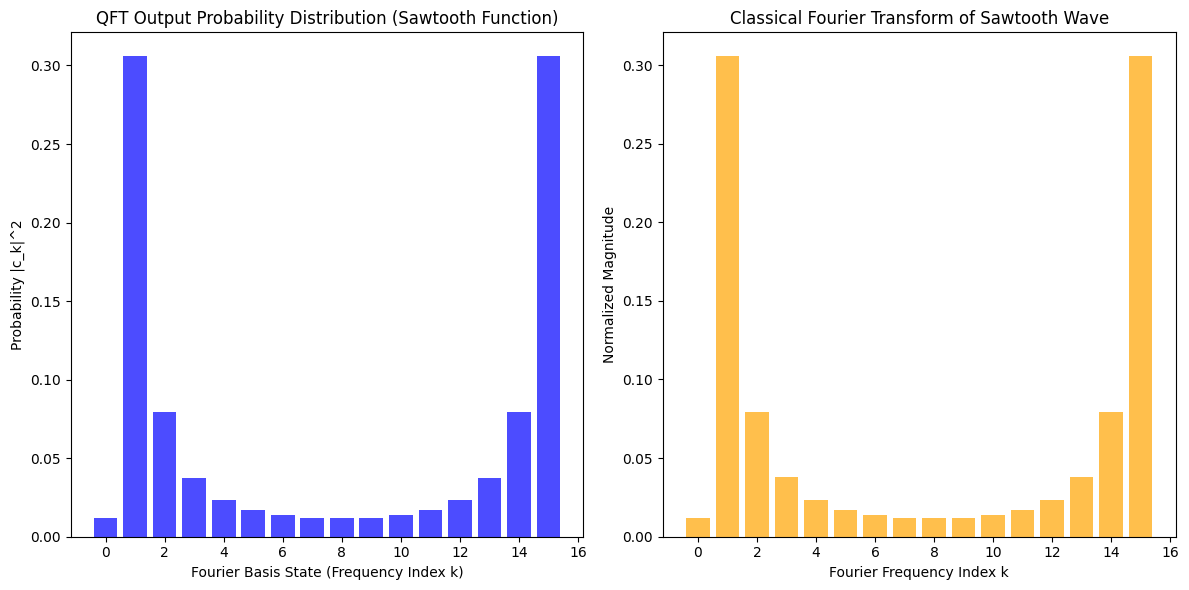

In [10]:
import pennylane as qml
from pennylane import numpy as np

n_wires = 4
dev = qml.device("default.qubit", wires=n_wires)

# Define the amplitudes you want to encode
amplitudes = np.array([
    -0.431, -0.377, -0.323, -0.27,
    -0.216, -0.162, -0.108, -0.054,
     0.0, 0.054, 0.108, 0.162,
     0.216, 0.27, 0.323, 0.377
])

# Normalize to make sure it's a valid state
#amplitudes /= np.linalg.norm(amplitudes)

# Create a unitary that maps the computational basis to the desired state
U = np.outer(amplitudes, np.eye(16)[0]) + np.eye(16) - np.outer(np.eye(16)[0], np.eye(16)[0])

@qml.qnode(dev)
def circuit():
    # Apply the unitary
    qml.QubitUnitary(U, wires=[0, 1, 2, 3])
   
    return qml.state()

# Run the circuit
state = circuit()
print(state)

@qml.qnode(dev)
def circuit():
    # Apply the unitary
    qml.QubitUnitary(U, wires=[0, 1, 2, 3])
    qft(num_qubits)
    return qml.probs()


#--------------------------------------Plottting the results--------------------------------------------
# Execute the QFT circuit
output_state = circuit()

# Print the resulting quantum state
print("Output quantum state:", output_state)

#-----------------------------------Plotting-----------------------------------

import matplotlib.pyplot as plt

# Classical Fourier Transform of the sawtooth wave
classical_fft = np.fft.fft(sawtooth_vals)
classical_probs = np.abs(classical_fft) ** 2
classical_probs /= np.sum(classical_probs)  # Normalize probabilities

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Quantum Fourier Transform output
ax1.bar(range(len(output_state)), output_state, color='blue', alpha=0.7)
ax1.set_title("QFT Output Probability Distribution (Sawtooth Function)")
ax1.set_xlabel("Fourier Basis State (Frequency Index k)")
ax1.set_ylabel("Probability |c_k|^2")

# Classical Fourier Transform output
ax2.bar(range(len(classical_probs)), classical_probs, color='orange', alpha=0.7)
ax2.set_title("Classical Fourier Transform of Sawtooth Wave")
ax2.set_xlabel("Fourier Frequency Index k")
ax2.set_ylabel("Normalized Magnitude")

plt.tight_layout()
plt.show()

Approach 3 is simpler: Amplitude Embedding simply

Output quantum state: [0.0116166  0.30598852 0.07919305 0.03749358 0.02317936 0.01681144
 0.01363209 0.01208536 0.0116166  0.01208536 0.01363209 0.01681144
 0.02317936 0.03749358 0.07919305 0.30598852]


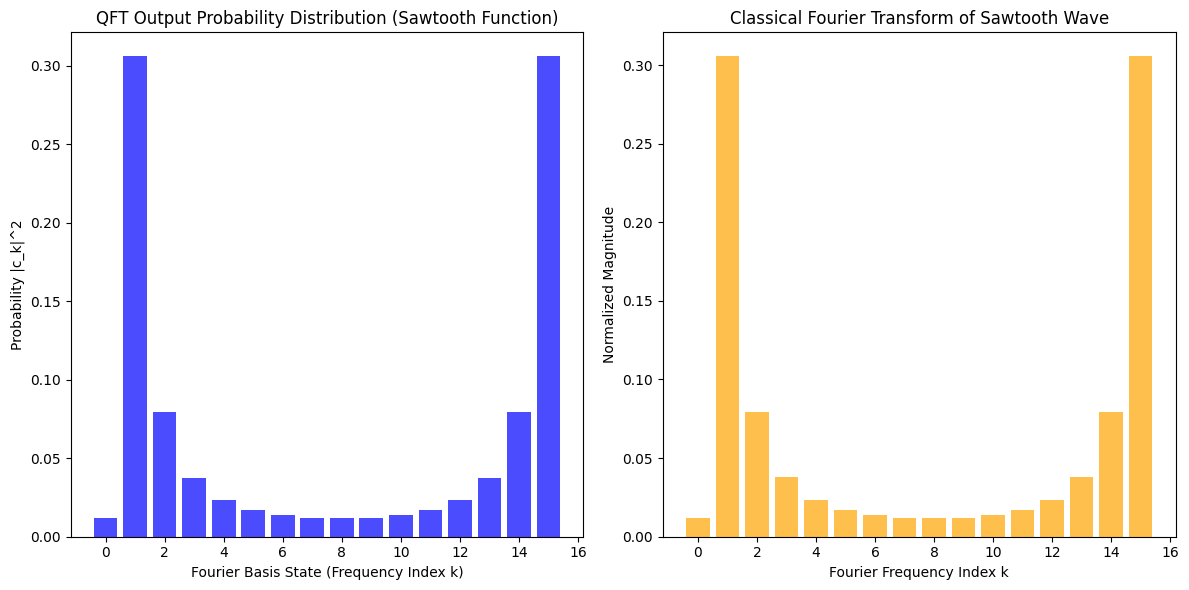

In [13]:
# Setup PennyLane device
dev = qml.device("default.qubit", wires=n_wires)

def amplitude_embedding_circuit():
    # Embed the sawtooth amplitudes
    qml.AmplitudeEmbedding(amplitudes, wires=range(n_wires), normalize=True)

@qml.qnode(dev)
def qft_circuit():
    """Quantum circuit that applies the QFT on Sawtooth state."""
    
    # Embed the sawtooth amplitudes
    amplitude_embedding_circuit()

    # Apply the QFT

    qft(num_qubits)
    
    # Return the quantum probabilities for each state
    return qml.probs()


output_state = qft_circuit()

# Print the resulting quantum state
print("Output quantum state:", output_state)

#-----------------------------------Plotting-----------------------------------

import matplotlib.pyplot as plt

# Classical Fourier Transform of the sawtooth wave
classical_fft = np.fft.fft(sawtooth_vals)
classical_probs = np.abs(classical_fft) ** 2
classical_probs /= np.sum(classical_probs)  # Normalize probabilities

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Quantum Fourier Transform output
ax1.bar(range(len(output_state)), output_state, color='blue', alpha=0.7)
ax1.set_title("QFT Output Probability Distribution (Sawtooth Function)")
ax1.set_xlabel("Fourier Basis State (Frequency Index k)")
ax1.set_ylabel("Probability |c_k|^2")

# Classical Fourier Transform output
ax2.bar(range(len(classical_probs)), classical_probs, color='orange', alpha=0.7)
ax2.set_title("Classical Fourier Transform of Sawtooth Wave")
ax2.set_xlabel("Fourier Frequency Index k")
ax2.set_ylabel("Normalized Magnitude")

plt.tight_layout()
plt.show()

#works perfectly! But we wish to make it with gates instead!

Approach 4: Approximation...If you want to approximate the amplitudes using rotations and try do manually do it without decomposition, it’s trickier because amplitudes aren’t directly set. However, you can map the amplitudes to rotation angles using controlled rotations.

REDACTED: This method is not possible. Check the states of this method. You will see it can only encode the all positive version of the sawtooth. This is because of our initial Y rotation at the start, which enforces that the sum weightings of the amplitudes remain positive - this is infact not the case. I thus believe it is not possible to only do this with controlled Y's.

REDACTED 2: It is possible, simply global phase the states you desire!

Prepared state probabilities: [-4.31000000e-01-5.27822770e-17j -3.77000000e-01-4.61691843e-17j
 -3.23000000e-01-3.95560916e-17j -2.70000000e-01-3.30654636e-17j
 -2.16000000e-01-2.64523709e-17j -1.62000000e-01-1.98392781e-17j
 -1.08000000e-01-1.32261854e-17j -5.40000000e-02-6.61309272e-18j
  3.30883344e-18+0.00000000e+00j  5.40373508e-02+0.00000000e+00j
  1.08074702e-01+0.00000000e+00j  1.62112053e-01+0.00000000e+00j
  2.16149403e-01+0.00000000e+00j  2.70186754e-01+0.00000000e+00j
  3.23223413e-01+0.00000000e+00j  3.77260764e-01+0.00000000e+00j]


c:\Users\Lloyd\miniconda3\envs\Lloyd_Quantum\Lib\site-packages\matplotlib\transforms.py:767: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


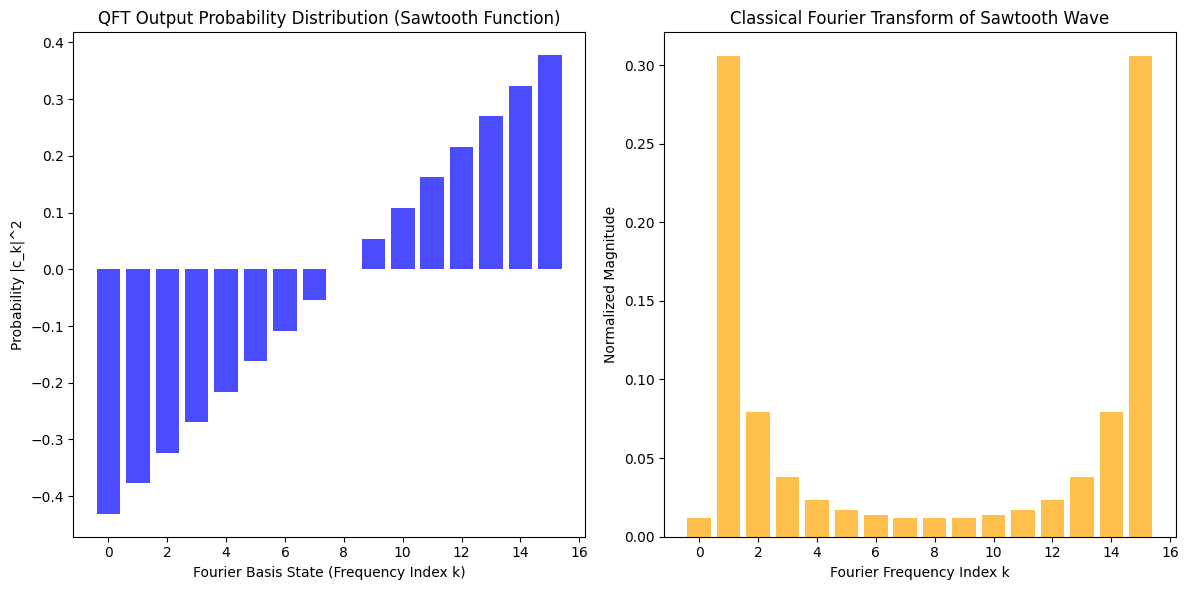

In [41]:
dev = qml.device("default.qubit", wires=n_wires)

# Execute the QFT with the prepared state.
@qml.qnode(dev)
def state_preparation():

    """Prepare the sawtooth state using gates."""
    # First layer: Encode the first qubit
    theta_0_1 = 2 * np.arccos(np.sqrt(np.sum(amplitudes[:8]**2)))
    qml.RY(theta_0_1, wires=0)

    # Second layer: Controlled rotations for the second qubit
    theta_00_01 = 2 * np.arccos(np.sqrt(np.sum(amplitudes[:4]**2) / np.sum(amplitudes[:8]**2)))
    qml.PauliX(wires=0)
    qml.CRY(theta_00_01, wires=[0, 1])
    qml.PauliX(wires=0)
    
    theta_10_11 = 2 * np.arccos(np.sqrt(np.sum(amplitudes[8:12]**2) / np.sum(amplitudes[8:16]**2)))
    qml.CRY(theta_10_11, wires=[0, 1])

    # Third layer: Multi-controlled rotations for the third qubit
    theta_000_001 = 2 * np.arccos(np.sqrt(np.sum(amplitudes[:2]**2) / np.sum(amplitudes[:4]**2)))
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    qml.ctrl(qml.RY, control=[0, 1])(theta_000_001, wires=2)
    #qml.CRY(theta_000_001, wires=[1, 2])
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)

    theta_010_011 = 2 * np.arccos(np.sqrt(np.sum(amplitudes[4:6]**2) / np.sum(amplitudes[4:8]**2)))
    qml.PauliX(wires=0)
    #qml.PauliX(wires=1)
    #qml.ctrl(qml.CRY, control=[0, 1])(theta_2_2, wires=2)
    qml.ctrl(qml.RY, control=[0, 1])(theta_010_011, wires=2)
    qml.PauliX(wires=0)
    #qml.PauliX(wires=1)
    
    theta_100_101 = 2 * np.arccos(np.sqrt(np.sum(amplitudes[8:10]**2) / np.sum(amplitudes[8:12]**2)))
    #qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    qml.ctrl(qml.RY, control=[0, 1])(theta_100_101, wires=2)
    #qml.CRY(theta_000_001, wires=[1, 2])
    #qml.PauliX(wires=0)
    qml.PauliX(wires=1)

    theta_110_111 = 2 * np.arccos(np.sqrt(np.sum(amplitudes[12:14]**2) / np.sum(amplitudes[12:16]**2)))
    #qml.PauliX(wires=0)
    #qml.PauliX(wires=1)
    #qml.ctrl(qml.CRY, control=[0, 1])(theta_2_2, wires=2)
    qml.ctrl(qml.RY, control=[0, 1])(theta_110_111, wires=2)
    #qml.PauliX(wires=0)
    #qml.PauliX(wires=1)
    
    # Fourth layer: Rotate the fourth qubit

    theta_0000_0001 = 2 * np.arccos(np.sqrt(np.sum(amplitudes[:1]**2) / np.sum(amplitudes[:2]**2)))
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    qml.PauliX(wires=2)
    qml.ctrl(qml.RY, control=[0, 1, 2])(theta_0000_0001, wires=3)
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    qml.PauliX(wires=2)

    theta_0010_0011 = 2 * np.arccos(np.sqrt(np.sum(amplitudes[2:3]**2) / np.sum(amplitudes[2:4]**2)))
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    #qml.ctrl(qml.CRY, control=[0, 1])(theta_2_2, wires=2)
    qml.ctrl(qml.RY, control=[0, 1, 2])(theta_0010_0011, wires=3)
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)

    theta_0100_0101 = 2 * np.arccos(np.sqrt(np.sum(amplitudes[4:5]**2) / np.sum(amplitudes[4:6]**2)))
    qml.PauliX(wires=0)
    #qml.PauliX(wires=1)
    qml.PauliX(wires=2)
    qml.ctrl(qml.RY, control=[0, 1, 2])(theta_0100_0101, wires=3)
    qml.PauliX(wires=0)
    #qml.PauliX(wires=1)
    qml.PauliX(wires=2)

    theta_0110_0111 = 2 * np.arccos(np.sqrt(np.sum(amplitudes[6:7]**2) / np.sum(amplitudes[6:8]**2)))
    qml.PauliX(wires=0)
    #qml.PauliX(wires=1)
    #qml.ctrl(qml.CRY, control=[0, 1])(theta_2_2, wires=2)
    qml.ctrl(qml.RY, control=[0, 1, 2])(theta_0110_0111, wires=3)
    qml.PauliX(wires=0)

    theta_1000_1001 = 2 * np.arccos(np.sqrt(np.sum(amplitudes[8:9]**2) / np.sum(amplitudes[8:10]**2)))
    #qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    qml.PauliX(wires=2)
    qml.ctrl(qml.RY, control=[0, 1, 2])(theta_1000_1001, wires=3)
    #qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    qml.PauliX(wires=2)

    theta_1010_1011 = 2 * np.arccos(np.sqrt(np.sum(amplitudes[10:11]**2) / np.sum(amplitudes[10:12]**2)))
    #qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    #qml.ctrl(qml.CRY, control=[0, 1])(theta_2_2, wires=2)
    qml.ctrl(qml.RY, control=[0, 1, 2])(theta_1010_1011, wires=3)
    #qml.PauliX(wires=0)
    qml.PauliX(wires=1)

    theta_1100_1101 = 2 * np.arccos(np.sqrt(np.sum(amplitudes[12:13]**2) / np.sum(amplitudes[12:14]**2)))
    #qml.PauliX(wires=0)
    #qml.PauliX(wires=1)
    qml.PauliX(wires=2)
    qml.ctrl(qml.RY, control=[0, 1, 2])(theta_1100_1101, wires=3)
    #qml.PauliX(wires=0)
    #qml.PauliX(wires=1)
    qml.PauliX(wires=2)

    theta_1110_1111 = 2 * np.arccos(np.sqrt(np.sum(amplitudes[14:15]**2) / np.sum(amplitudes[14:16]**2)))
    #qml.PauliX(wires=0)
    #qml.PauliX(wires=1)
    #qml.ctrl(qml.CRY, control=[0, 1])(theta_2_2, wires=2)
    qml.ctrl(qml.RY, control=[0, 1, 2])(theta_1110_1111, wires=3)
    #qml.PauliX(wires=0)
    #qml.PauliX(wires=1)
    
    #Apply conditional phase flippings with Z gates in order to correctly represent positives and negatives of sawtooth wave
    #This means essentially flip the first 8 states
    qml.PauliX(wires=0)
    qml.ctrl(qml.GlobalPhase, control=0)(np.pi,wires=1) #doesn't matter which wire to put the phase shift onto
    qml.PauliX(wires=0)
    
    #qft(num_qubits)    
    
    return qml.state()


prepared_probs = state_preparation()


# Print the resulting probabilities
print("Prepared state probabilities:", prepared_probs)

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Quantum Fourier Transform output
ax1.bar(range(len(prepared_probs)), prepared_probs, color='blue', alpha=0.7)
ax1.set_title("QFT Output Probability Distribution (Sawtooth Function)")
ax1.set_xlabel("Fourier Basis State (Frequency Index k)")
ax1.set_ylabel("Probability |c_k|^2")

# Classical Fourier Transform output
ax2.bar(range(len(classical_probs)), classical_probs, color='orange', alpha=0.7)
ax2.set_title("Classical Fourier Transform of Sawtooth Wave")
ax2.set_xlabel("Fourier Frequency Index k")
ax2.set_ylabel("Normalized Magnitude")

plt.tight_layout()
plt.show()


(<Figure size 5200x500 with 1 Axes>, <Axes: >)

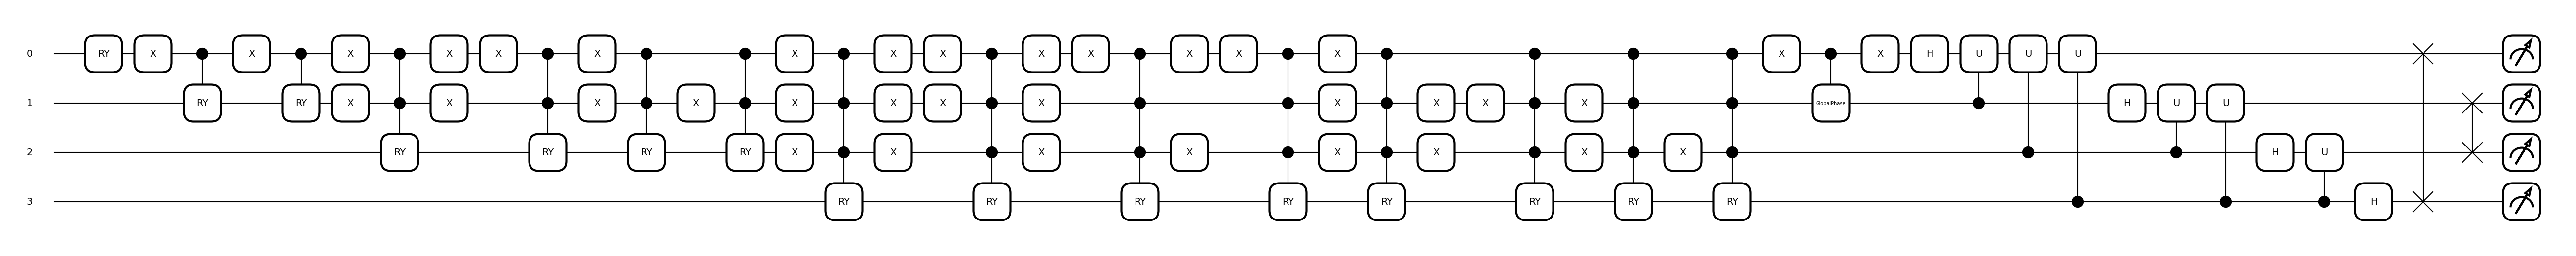

In [40]:
qml.draw_mpl(state_preparation, show_matrices=True)()